# Bulk processing of 0337 data

This notebook is for controlling the bulk processing of 0337 observations. Using the first section, set up which processing spec to use to generate TOAs and summary plots. Then there are blocks to summarize what's on disk, run a small number of test observations, collect summary plots and TOAs, clear out old processing data, and various other tasks that require working with the full data layout.

## Importing new data

Put new data in with the old, under `/psr/archive/hessels/archibald/0337+17/raw`:
* GBT - Put this under `.../raw/GBT/new`, with the other not-processed-by-Scott data
* AO - Put this under `.../raw/AO`
* WSRT - Put this under `.../raw/WSRT`, by date as with the others

Run `pac-preparation.ipynb` to index the new calibrator scans. Then run the appropriate import notebook:
* GBT - `collect-uppi-data.ipynb`
* AO - `collect-puppi-data.ipynb`
* WSRT - `collect-wsrt-data.ipynb` - in contrast to the other two, which just index and then copy the files, this must realign and concatenate the raw files, so this takes a fair bit of time and memory to run

Finally you should probably run `maintain-symlinks.ipynb` to make sure the collected raw data is immortalized on `/psr_archive`.

In [2]:
%load_ext autoreload

%autoreload 2

import os
from glob import glob
import subprocess
import shutil
import traceback
import random
import pickle
from os.path import join

import joblib
from concurrent.futures import ProcessPoolExecutor

from backports import tempfile

import matplotlib
matplotlib.rcParams['savefig.dpi'] = 144
matplotlib.rcParams["image.composite_image"]=False
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from numpy.fft import rfft, irfft, fft, ifft
from astropy.io import fits

import psrchive
import residuals

import pipe
from pipe import rotate_phase, convert_template, align_profile, align_scale_profile
import make_toas

plt.viridis()

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Processing selection

In [37]:
#processing_name = "wideband"
#processing_name = "subband"
#processing_name = "singlefrequency"
#processing_name = "onescintle"
processing_name = "tuned"
#processing_name = "sband"
#toa_name = "normal"
toa_name = "mueller"


processing_specs = pickle.load(open("processing_specs.pickle","rb"))
toa_specs = pickle.load(open("toa_specs.pickle","rb"))



processing_specs[processing_name]
toa_specs[toa_name]

print processing_name, toa_name

tuned mueller


## Report status

Summarize processed observations.

In [58]:
processing_names = {}
toa_names = {}
total = 0
for o in sorted(glob("data/obs/*_*_*")):
    total += 1
    for d in os.listdir(o):
        if os.path.isdir(join(o,d)):
            if d not in processing_names:
                processing_names[d] = 0
            processing_names[d] += 1
            for t in os.listdir(join(o,d)):
                if os.path.isdir(join(o,d,t)):
                    if (d,t) not in toa_names:
                        toa_names[d,t] = 0
                    toa_names[d,t] += 1
for k,v in sorted(processing_names.items()):
    print k, v
print
for k,v in sorted(toa_names.items()):
    print k, v
print
print "total", total

junk 2
onescintle 670
sband 11
singlefrequency 12
test1 2
toa-testing 3
toa-testing-2 7
tuned 790
tuned2 224
wideband 630

('onescintle', 'mueller') 670
('onescintle', 'normal') 4
('sband', 'mueller') 10
('singlefrequency', 'normal') 12
('toa-testing-2', 'normal') 5
('tuned', 'mueller') 788
('tuned2', 'aligned') 223
('wideband', 'normal') 628

total 812


## Process observations

For large-scale processing, use `make_toas.py`. This supports parallel processing (though more than two jobs risks overloading the RAM and causing disk thrashing), and can be asked to stop when errors occur. Also it's smart enough to skip observations known to be bad, and running many observations through the notebook risks causing browser meltdowns as zillions of lines of output and hundreds of PNGs get loaded. But running small numbers here is a good way to test out a new processing spec or a code change. For detailed testing of code changes, look at other notebooks that process observations in a persistent working directory, as this can save very substantial amounts of reprocessing.

Note that both this and `make_toas.py` treat the existence of a processed-products directory as meaning that the observation has been successfully processed. Thus this only processes new observations or ones for which the products have been deleted; thus if you want to trigger reprocessing, delete the products. There are blocks below to do that under various circumstances.

In [102]:
demo_obs = ["data/obs/56117.50_AO_1400",
            "data/obs/56494.49_GBT_1400",
            "data/obs/56070.64_AO_430",
            "data/obs/56479.20_WSRT_350",
            "data/obs/56496.15_WSRT_1400",
            "data/obs/56050.72_AO_1400"]
for o in demo_obs:
    make_toas.generate_specific(o, processing_name, toa_name)

data/obs/56117.50_AO_1400 tuned mueller
data/obs/56494.49_GBT_1400 tuned mueller
data/obs/56070.64_AO_430 tuned mueller
data/obs/56479.20_WSRT_350 tuned mueller
data/obs/56496.15_WSRT_1400 tuned mueller
data/obs/56050.72_AO_1400 tuned mueller


In [ ]:
# top-SNR observations from the GBT for use in building a template profile
p = "singlefrequency"
profile_obsns = [(72147.438642543886, '56412.76_GBT_1400'), 
             (68267.325089264225, '56321.01_GBT_1400'), 
             (67777.17230122973, '56142.50_GBT_1400'), 
             (66221.79141810436, '56234.25_GBT_1400'), 
             (60884.632224439782, '56506.42_GBT_1400'), 
             (49579.207341495159, '56690.92_GBT_1400'), 
             (45528.897719101544, '56527.34_GBT_1400')]
profile_obsns = [join("data","obs",o) for (s,o) in profile_obsns]
for o in profile_obsns:
    make_toas.generate_specific(o, p, toa_name)


data/obs/56412.76_GBT_1400 singlefrequency mueller


In [ ]:
pol_obs = ["data/obs/56207.39_GBT_1400",
           "data/obs/56214.26_GBT_1400",
           "data/obs/56477.53_AO_1400",
           "data/obs/56412.76_GBT_1400",
          ]
processes = ["wideband", "singlefrequency"]
for o in pol_obs:
    for p in processes:
        print o, p
        make_toas.generate_specific(o, p, toa_name)

INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triplecpRtwa/raw_0000.ar'], {'output': '/data/archibald/scratch/triplecpRtwa/align_0000.ar', 'E': '/data/archibald/0337+1715/ephemerides/57400.par', 'ephver': 'tempo'}) != ([], {})
INFO:root:Output /data/archibald/scratch/triplecpRtwa/align_0000.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triplecpRtwa/raw_0000.ar with keyword output=/data/archibald/scratch/triplecpRtwa/align_0000.ar
INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triplecpRtwa/raw_0001.ar'], {'output': '/data/archibald/scratch/triplecpRtwa/align_0001.ar', 'E': '/data/archibald/0337+1715/ephemerides/57400.par', 'ephver': 'tempo'}) != ([], {})
INFO:root:Output /data/archibald/scratch/triplecpRtwa/align_0001.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triplecpRtwa/raw_0001.ar with keyword output=/data/archi

/data/archibald/scratch/triplecpRtwa/align_0000.ar written to disk


INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triplecpRtwa/raw_0002.ar'], {'output': '/data/archibald/scratch/triplecpRtwa/align_0002.ar', 'E': '/data/archibald/0337+1715/ephemerides/57400.par', 'ephver': 'tempo'}) != ([], {})
INFO:root:Output /data/archibald/scratch/triplecpRtwa/align_0002.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triplecpRtwa/raw_0002.ar with keyword output=/data/archibald/scratch/triplecpRtwa/align_0002.ar


/data/archibald/scratch/triplecpRtwa/align_0001.ar written to disk
/data/archibald/scratch/triplecpRtwa/align_0002.ar written to disk


INFO:root:Zapping ['/data/archibald/scratch/triplecpRtwa/cal_0000.ar', '/data/archibald/scratch/triplecpRtwa/cal_0001.ar', '/data/archibald/scratch/triplecpRtwa/cal_0002.ar']
INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triplecpRtwa/cal_0000.ar', '-F', '980 1150', '-F', '1618 1630'], {'output': '/data/archibald/scratch/triplecpRtwa/zaptemp_0000.ar', 'R': 20, 'r': None}) != ([], {})
INFO:root:Output /data/archibald/scratch/triplecpRtwa/zaptemp_0000.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triplecpRtwa/cal_0000.ar with keyword output=/data/archibald/scratch/triplecpRtwa/zaptemp_0000.ar


Using median smoothed difference zapper
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 131 132 149 150 151 162 163 286 311 312 344 386 387 388 398 399 406 414 415 422 423 426 427 428 429 430 431 432 433 434 435 438 439 442 443 446 447"
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 111 112 131 132 149 150 151 157 162 163 311 312 320 321 327 344 345 386 387 388 389 398 399 406 407 414 415 422 423 426 427 428 429 430 431 432 433 434 435 438 439 442 443 446 447"
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 131 132 149 150 151 162 163 286 311 312 320 323 324 334 335 344 345 366 386 387 388 389 398 399 406 410 414 415 422 423 426 427 428 429 430 431 432 433 434 435 438 439 442 443 446 447"
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 131 132 149 150 151 162 163 286 311 312 320 323 324 334 335 344 345 386 387 388 389 398 399 406 410 414 415 422 423 426 427 428 429 430 431 432 433 434 435 438 439 442 443 446 447"
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 131 132 149 150 151 157 

INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triplecpRtwa/cal_0001.ar', '-F', '980 1150', '-F', '1618 1630'], {'output': '/data/archibald/scratch/triplecpRtwa/zaptemp_0001.ar', 'R': 20, 'r': None}) != ([], {})
INFO:root:Output /data/archibald/scratch/triplecpRtwa/zaptemp_0001.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triplecpRtwa/cal_0001.ar with keyword output=/data/archibald/scratch/triplecpRtwa/zaptemp_0001.ar


Using median smoothed difference zapper
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 131 132 149 150 162 163 311 312 327 344 345 354 355 366 367 386 398 399 406 414 415 422 423 426 427 428 429 430 431 432 433 434 435 438 439 442 443 446 447"
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 131 132 149 150 151 162 163 311 312 320 327 330 344 345 354 355 367 368 386 387 388 398 399 406 410 414 415 422 423 426 427 428 429 430 431 432 433 434 435 438 439 442 443 446 447"
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 130 131 132 150 151 162 163 311 312 327 330 344 345 354 355 367 386 387 398 399 406 414 415 422 423 426 427 428 429 430 431 432 433 434 435 438 439 442 443 446 447"
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 100 101 131 132 140 141 149 150 157 158 162 163 311 312 326 327 328 330 344 345 354 386 387 388 398 399 406 410 414 415 422 423 426 427 428 429 430 431 432 433 434 435 438 439 442 443 446 447"
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 100 131 132 140 141 149 

INFO:root:Zapping subintegrations in ZA keyhole: [43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
INFO:root:ZAs: [1.1220055101042021, 1.107360112799384, 1.0940316190281862, 1.0820729255877666, 1.0715298966250373, 1.0624446785275978, 1.0548549386732873, 1.0487931456297446, 1.0442859074747588, 1.0413534101533344, 1.0400089747269305, 1.0402587585456047, 1.0421016152353104, 1.0455279957745631, 1.0505242232558487, 1.0570614940427845, 1.0651217981091747, 1.0746663476933236, 1.0856528750649517, 1.0980438659516665, 1.1117897136041677]
INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triplecpRtwa/zaptemp_0001.ar'], {'output': '/data/archibald/scratch/triplecpRtwa/zaptemp2_0001.ar', 'w': '43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63'}) != ([], {})
INFO:root:Output /data/archibald/scratch/triplecpRtwa/zaptemp2_0001.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/t

Updating /data/archibald/scratch/triplecpRtwa/zaptemp2_0001.ar ... done


INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triplecpRtwa/cal_0002.ar', '-F', '980 1150', '-F', '1618 1630'], {'output': '/data/archibald/scratch/triplecpRtwa/zaptemp_0002.ar', 'R': 20, 'r': None}) != ([], {})
INFO:root:Output /data/archibald/scratch/triplecpRtwa/zaptemp_0002.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triplecpRtwa/cal_0002.ar with keyword output=/data/archibald/scratch/triplecpRtwa/zaptemp_0002.ar


Using median smoothed difference zapper
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 101 115 131 132 148 149 150 157 158 162 163 286 311 312 323 327 344 345 386 387 398 399 406 414 415 422 423 426 427 428 429 430 431 432 433 434 435 438 439 442 443 446 447"
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 101 102 131 132 148 149 150 151 157 158 162 163 286 287 311 323 327 328 330 344 345 386 387 388 398 399 406 414 415 422 423 426 427 428 429 430 431 432 433 434 435 438 439 442 443 446 447"
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 101 102 131 132 148 149 150 157 162 163 286 311 312 327 344 345 366 386 398 399 406 414 415 422 423 426 427 428 429 430 431 432 433 434 435 438 439 442 443 446 447"
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 131 132 148 149 150 162 163 286 311 312 320 327 344 345 386 398 399 406 414 415 422 423 426 427 428 429 430 431 432 433 434 435 438 439 442 443 446 447"
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 131 132 149 150 157 158 162 163 275 286 

INFO:root:Zapping subintegrations in ZA keyhole: [0]
INFO:root:ZAs: [1.1268408348116026]
INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triplecpRtwa/zaptemp_0002.ar'], {'output': '/data/archibald/scratch/triplecpRtwa/zaptemp2_0002.ar', 'w': '0'}) != ([], {})
INFO:root:Output /data/archibald/scratch/triplecpRtwa/zaptemp2_0002.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triplecpRtwa/zaptemp_0002.ar with keyword output=/data/archibald/scratch/triplecpRtwa/zaptemp2_0002.ar


Updating /data/archibald/scratch/triplecpRtwa/zaptemp2_0002.ar ... done


INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triplecpRtwa/zap_0000.ar'], {'setnchn': 1, 'output': '/data/archibald/scratch/triplecpRtwa/scrunchtemp_0000.ar'}) != ([], {})
INFO:root:Output /data/archibald/scratch/triplecpRtwa/scrunchtemp_0000.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triplecpRtwa/zap_0000.ar with keyword output=/data/archibald/scratch/triplecpRtwa/scrunchtemp_0000.ar
INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triplecpRtwa/zap_0001.ar'], {'setnchn': 1, 'output': '/data/archibald/scratch/triplecpRtwa/scrunchtemp_0001.ar'}) != ([], {})
INFO:root:Output /data/archibald/scratch/triplecpRtwa/scrunchtemp_0001.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triplecpRtwa/zap_0001.ar with keyword output=/data/archibald/scratch/triplecpRtwa/scrunchtemp_0001.ar


/data/archibald/scratch/triplecpRtwa/scrunchtemp_0000.ar written to disk


INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triplecpRtwa/zap_0002.ar'], {'setnchn': 1, 'output': '/data/archibald/scratch/triplecpRtwa/scrunchtemp_0002.ar'}) != ([], {})
INFO:root:Output /data/archibald/scratch/triplecpRtwa/scrunchtemp_0002.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triplecpRtwa/zap_0002.ar with keyword output=/data/archibald/scratch/triplecpRtwa/scrunchtemp_0002.ar


/data/archibald/scratch/triplecpRtwa/scrunchtemp_0001.ar written to disk
/data/archibald/scratch/triplecpRtwa/scrunchtemp_0002.ar written to disk


ERROR:root:Metadata claims 29 subints but files contain 157 for observation 57400.02_AO_1400; overriding
INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triplecpRtwa/scrunchadd_0000.ar'], {'output': '/data/archibald/scratch/triplecpRtwa/scrunch_0000.ar', 'setnsub': 157}) != ([], {})
INFO:root:Output /data/archibald/scratch/triplecpRtwa/scrunch_0000.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triplecpRtwa/scrunchadd_0000.ar with keyword output=/data/archibald/scratch/triplecpRtwa/scrunch_0000.ar
DEBUG:root:Scrunch requested 1 channels from 448 got 1
DEBUG:root:Scrunch requested 157 subints from 157 got 157


/data/archibald/scratch/triplecpRtwa/scrunch_0000.ar written to disk


INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triple08vCUg/raw_0000.ar'], {'output': '/data/archibald/scratch/triple08vCUg/align_0000.ar', 'E': '/data/archibald/0337+1715/ephemerides/56004.par', 'ephver': 'tempo'}) != ([], {})
INFO:root:Output /data/archibald/scratch/triple08vCUg/align_0000.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triple08vCUg/raw_0000.ar with keyword output=/data/archibald/scratch/triple08vCUg/align_0000.ar
INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triple08vCUg/raw_0001.ar'], {'output': '/data/archibald/scratch/triple08vCUg/align_0001.ar', 'E': '/data/archibald/0337+1715/ephemerides/56004.par', 'ephver': 'tempo'}) != ([], {})
INFO:root:Output /data/archibald/scratch/triple08vCUg/align_0001.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triple08vCUg/raw_0001.ar with keyword output=/data/archi

/data/archibald/scratch/triple08vCUg/align_0000.ar written to disk


INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triple08vCUg/raw_0002.ar'], {'output': '/data/archibald/scratch/triple08vCUg/align_0002.ar', 'E': '/data/archibald/0337+1715/ephemerides/56004.par', 'ephver': 'tempo'}) != ([], {})
INFO:root:Output /data/archibald/scratch/triple08vCUg/align_0002.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triple08vCUg/raw_0002.ar with keyword output=/data/archibald/scratch/triple08vCUg/align_0002.ar


/data/archibald/scratch/triple08vCUg/align_0001.ar written to disk


INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triple08vCUg/raw_0003.ar'], {'output': '/data/archibald/scratch/triple08vCUg/align_0003.ar', 'E': '/data/archibald/0337+1715/ephemerides/56004.par', 'ephver': 'tempo'}) != ([], {})
INFO:root:Output /data/archibald/scratch/triple08vCUg/align_0003.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triple08vCUg/raw_0003.ar with keyword output=/data/archibald/scratch/triple08vCUg/align_0003.ar


/data/archibald/scratch/triple08vCUg/align_0002.ar written to disk


INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triple08vCUg/raw_0004.ar'], {'output': '/data/archibald/scratch/triple08vCUg/align_0004.ar', 'E': '/data/archibald/0337+1715/ephemerides/56004.par', 'ephver': 'tempo'}) != ([], {})
INFO:root:Output /data/archibald/scratch/triple08vCUg/align_0004.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triple08vCUg/raw_0004.ar with keyword output=/data/archibald/scratch/triple08vCUg/align_0004.ar


/data/archibald/scratch/triple08vCUg/align_0003.ar written to disk


INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triple08vCUg/raw_0005.ar'], {'output': '/data/archibald/scratch/triple08vCUg/align_0005.ar', 'E': '/data/archibald/0337+1715/ephemerides/56004.par', 'ephver': 'tempo'}) != ([], {})
INFO:root:Output /data/archibald/scratch/triple08vCUg/align_0005.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triple08vCUg/raw_0005.ar with keyword output=/data/archibald/scratch/triple08vCUg/align_0005.ar


/data/archibald/scratch/triple08vCUg/align_0004.ar written to disk
/data/archibald/scratch/triple08vCUg/align_0005.ar written to disk


INFO:root:Zapping ['/data/archibald/scratch/triple08vCUg/cal_0000.ar', '/data/archibald/scratch/triple08vCUg/cal_0001.ar', '/data/archibald/scratch/triple08vCUg/cal_0002.ar', '/data/archibald/scratch/triple08vCUg/cal_0003.ar', '/data/archibald/scratch/triple08vCUg/cal_0004.ar', '/data/archibald/scratch/triple08vCUg/cal_0005.ar']
INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triple08vCUg/cal_0000.ar', '-F', '980 1150', '-F', '1618 1630'], {'output': '/data/archibald/scratch/triple08vCUg/zaptemp_0000.ar', 'R': 20, 'r': None}) != ([], {})
INFO:root:Output /data/archibald/scratch/triple08vCUg/zaptemp_0000.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triple08vCUg/cal_0000.ar with keyword output=/data/archibald/scratch/triple08vCUg/zaptemp_0000.ar


Using median smoothed difference zapper
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 10 11 12 13 97 98 99 100 101 102 103 104 105 106 147 156 224 225 237 238 239 275 276 277 288 289 290 326 327 328 330 335 336 337 339 340 341 342 343 344 345 346 347 350 351 352 353 356 390 397 398 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511"
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 10 11 12 13 97 98 99 100 101 102 103 104 105 106 147 148 224 225 237 238 239 275 276 277 288 289 290 326 327 328 330 335 336 337 339 340 341 342 343 344 345 346 347 350 351 352 353 356 390 397 398 401 402 403 404 405 406 4

INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triple08vCUg/cal_0001.ar', '-F', '980 1150', '-F', '1618 1630'], {'output': '/data/archibald/scratch/triple08vCUg/zaptemp_0001.ar', 'R': 20, 'r': None}) != ([], {})
INFO:root:Output /data/archibald/scratch/triple08vCUg/zaptemp_0001.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triple08vCUg/cal_0001.ar with keyword output=/data/archibald/scratch/triple08vCUg/zaptemp_0001.ar


Using median smoothed difference zapper
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 10 11 12 13 97 98 99 100 101 102 103 104 105 106 147 148 156 224 225 237 238 239 275 276 277 288 289 290 326 327 328 330 335 336 337 339 340 341 342 343 344 345 346 347 350 351 352 353 356 369 390 397 398 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511"
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 10 11 12 13 97 98 99 100 101 102 103 104 105 106 147 148 224 225 237 238 239 275 276 277 288 289 290 326 327 328 330 335 336 337 339 340 341 342 343 344 345 346 347 350 351 352 353 356 390 397 398 401 402 403 404 4

INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triple08vCUg/cal_0002.ar', '-F', '980 1150', '-F', '1618 1630'], {'output': '/data/archibald/scratch/triple08vCUg/zaptemp_0002.ar', 'R': 20, 'r': None}) != ([], {})
INFO:root:Output /data/archibald/scratch/triple08vCUg/zaptemp_0002.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triple08vCUg/cal_0002.ar with keyword output=/data/archibald/scratch/triple08vCUg/zaptemp_0002.ar


Using median smoothed difference zapper
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 10 11 12 13 57 58 97 98 99 100 101 102 103 104 105 106 131 147 148 156 224 225 237 238 239 275 276 277 288 289 290 326 327 328 330 335 336 337 339 340 341 342 343 344 345 346 347 350 351 352 353 356 369 390 397 398 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511"
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 10 11 12 13 57 60 97 98 99 100 101 102 103 104 105 106 147 224 225 237 238 239 275 276 277 288 289 290 326 327 328 330 335 336 337 339 340 341 342 343 344 345 346 347 350 351 352 353 356 390 397 398 401 4

INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triple08vCUg/cal_0003.ar', '-F', '980 1150', '-F', '1618 1630'], {'output': '/data/archibald/scratch/triple08vCUg/zaptemp_0003.ar', 'R': 20, 'r': None}) != ([], {})
INFO:root:Output /data/archibald/scratch/triple08vCUg/zaptemp_0003.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triple08vCUg/cal_0003.ar with keyword output=/data/archibald/scratch/triple08vCUg/zaptemp_0003.ar


Using median smoothed difference zapper
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 10 11 12 13 97 98 99 100 101 102 103 104 105 106 131 147 224 225 237 238 239 275 276 277 288 289 290 326 327 328 330 335 336 337 339 340 341 342 343 344 345 346 347 350 351 352 353 356 397 398 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511"
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 10 11 12 13 97 98 99 100 101 102 103 104 105 106 131 132 147 224 225 237 238 239 275 276 277 288 289 290 326 327 328 330 335 336 337 339 340 341 342 343 344 345 346 347 350 351 352 353 356 397 398 403 404 405 406 407 408 409 410 411 4

INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triple08vCUg/cal_0004.ar', '-F', '980 1150', '-F', '1618 1630'], {'output': '/data/archibald/scratch/triple08vCUg/zaptemp_0004.ar', 'R': 20, 'r': None}) != ([], {})
INFO:root:Output /data/archibald/scratch/triple08vCUg/zaptemp_0004.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triple08vCUg/cal_0004.ar with keyword output=/data/archibald/scratch/triple08vCUg/zaptemp_0004.ar


Using median smoothed difference zapper
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 10 11 12 13 97 98 99 100 101 102 103 104 105 106 147 148 156 224 225 237 238 239 275 276 277 288 289 290 326 327 328 330 335 336 337 339 340 341 342 343 344 345 346 347 350 351 352 353 356 369 390 397 398 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511"
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 10 11 12 13 97 98 99 100 101 102 103 104 105 106 147 148 224 225 237 238 239 275 276 277 288 289 290 326 327 328 330 335 336 337 339 340 341 342 343 344 345 346 347 350 351 352 353 356 397 398 403 404 405 406 407 4

INFO:root:Zapping subintegrations in ZA keyhole: [56, 57, 58, 59, 60, 61, 62, 63]
INFO:root:ZAs: [1.1187379616671222, 1.1054485833336116, 1.093512424822805, 1.0829806983395116, 1.0738912584722442, 1.0662809907888402, 1.0601803252689308, 1.0556187153796657]
INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triple08vCUg/zaptemp_0004.ar'], {'output': '/data/archibald/scratch/triple08vCUg/zaptemp2_0004.ar', 'w': '56 57 58 59 60 61 62 63'}) != ([], {})
INFO:root:Output /data/archibald/scratch/triple08vCUg/zaptemp2_0004.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triple08vCUg/zaptemp_0004.ar with keyword output=/data/archibald/scratch/triple08vCUg/zaptemp2_0004.ar


Updating /data/archibald/scratch/triple08vCUg/zaptemp2_0004.ar ... done


INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triple08vCUg/cal_0005.ar', '-F', '980 1150', '-F', '1618 1630'], {'output': '/data/archibald/scratch/triple08vCUg/zaptemp_0005.ar', 'R': 20, 'r': None}) != ([], {})
INFO:root:Output /data/archibald/scratch/triple08vCUg/zaptemp_0005.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triple08vCUg/cal_0005.ar with keyword output=/data/archibald/scratch/triple08vCUg/zaptemp_0005.ar


Using median smoothed difference zapper
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 10 11 12 13 97 98 99 100 101 102 103 104 105 106 131 147 224 225 237 238 239 275 276 277 288 289 290 326 327 328 330 335 336 337 339 340 341 342 343 344 345 346 347 350 351 352 353 356 397 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511"
Equivalent paz cmd: paz -z "0 1 2 3 4 5 6 7 8 9 10 11 12 13 97 98 99 100 101 102 103 104 105 106 147 224 225 237 238 239 275 276 277 288 289 290 326 327 328 330 335 336 337 339 340 341 342 343 344 345 346 347 350 351 352 353 356 397 403 404 405 406 407 408 409 410 411 412 413 414 415 4

INFO:root:Zapping subintegrations in ZA keyhole: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
INFO:root:ZAs: [1.0526160941887497, 1.0511809958892684, 1.051322883801987, 1.053041120470155, 1.0563290987146416, 1.0611704834489473, 1.0675447995945575, 1.0754247889500306, 1.0847803287624913, 1.0955686963896198, 1.1077502623844708, 1.1212796214533114]
INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triple08vCUg/zaptemp_0005.ar'], {'output': '/data/archibald/scratch/triple08vCUg/zaptemp2_0005.ar', 'w': '0 1 2 3 4 5 6 7 8 9 10 11'}) != ([], {})
INFO:root:Output /data/archibald/scratch/triple08vCUg/zaptemp2_0005.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triple08vCUg/zaptemp_0005.ar with keyword output=/data/archibald/scratch/triple08vCUg/zaptemp2_0005.ar


Updating /data/archibald/scratch/triple08vCUg/zaptemp2_0005.ar ... done


INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triple08vCUg/zap_0000.ar'], {'setnchn': 1, 'output': '/data/archibald/scratch/triple08vCUg/scrunchtemp_0000.ar'}) != ([], {})
INFO:root:Output /data/archibald/scratch/triple08vCUg/scrunchtemp_0000.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triple08vCUg/zap_0000.ar with keyword output=/data/archibald/scratch/triple08vCUg/scrunchtemp_0000.ar
INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triple08vCUg/zap_0001.ar'], {'setnchn': 1, 'output': '/data/archibald/scratch/triple08vCUg/scrunchtemp_0001.ar'}) != ([], {})
INFO:root:Output /data/archibald/scratch/triple08vCUg/scrunchtemp_0001.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triple08vCUg/zap_0001.ar with keyword output=/data/archibald/scratch/triple08vCUg/scrunchtemp_0001.ar


/data/archibald/scratch/triple08vCUg/scrunchtemp_0000.ar written to disk


INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triple08vCUg/zap_0002.ar'], {'setnchn': 1, 'output': '/data/archibald/scratch/triple08vCUg/scrunchtemp_0002.ar'}) != ([], {})
INFO:root:Output /data/archibald/scratch/triple08vCUg/scrunchtemp_0002.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triple08vCUg/zap_0002.ar with keyword output=/data/archibald/scratch/triple08vCUg/scrunchtemp_0002.ar


/data/archibald/scratch/triple08vCUg/scrunchtemp_0001.ar written to disk


INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triple08vCUg/zap_0003.ar'], {'setnchn': 1, 'output': '/data/archibald/scratch/triple08vCUg/scrunchtemp_0003.ar'}) != ([], {})
INFO:root:Output /data/archibald/scratch/triple08vCUg/scrunchtemp_0003.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triple08vCUg/zap_0003.ar with keyword output=/data/archibald/scratch/triple08vCUg/scrunchtemp_0003.ar


/data/archibald/scratch/triple08vCUg/scrunchtemp_0002.ar written to disk


INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triple08vCUg/zap_0004.ar'], {'setnchn': 1, 'output': '/data/archibald/scratch/triple08vCUg/scrunchtemp_0004.ar'}) != ([], {})
INFO:root:Output /data/archibald/scratch/triple08vCUg/scrunchtemp_0004.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triple08vCUg/zap_0004.ar with keyword output=/data/archibald/scratch/triple08vCUg/scrunchtemp_0004.ar


/data/archibald/scratch/triple08vCUg/scrunchtemp_0003.ar written to disk


INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triple08vCUg/zap_0005.ar'], {'setnchn': 1, 'output': '/data/archibald/scratch/triple08vCUg/scrunchtemp_0005.ar'}) != ([], {})
INFO:root:Output /data/archibald/scratch/triple08vCUg/scrunchtemp_0005.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triple08vCUg/zap_0005.ar with keyword output=/data/archibald/scratch/triple08vCUg/scrunchtemp_0005.ar


/data/archibald/scratch/triple08vCUg/scrunchtemp_0004.ar written to disk
/data/archibald/scratch/triple08vCUg/scrunchtemp_0005.ar written to disk


ERROR:root:Metadata claims 61 subints but files contain 381 for observation 56005.83_AO_1400; overriding
INFO:root:No old arguments on record
INFO:root:Arguments changed
DEBUG:root:(['/data/archibald/scratch/triple08vCUg/scrunchadd_0000.ar'], {'output': '/data/archibald/scratch/triple08vCUg/scrunch_0000.ar', 'setnsub': 381}) != ([], {})
INFO:root:Output /data/archibald/scratch/triple08vCUg/scrunch_0000.ar missing
DEBUG:root:Inplace replacing position 0=/data/archibald/scratch/triple08vCUg/scrunchadd_0000.ar with keyword output=/data/archibald/scratch/triple08vCUg/scrunch_0000.ar
DEBUG:root:Scrunch requested 1 channels from 512 got 1
DEBUG:root:Scrunch requested 381 subints from 381 got 381


/data/archibald/scratch/triple08vCUg/scrunch_0000.ar written to disk


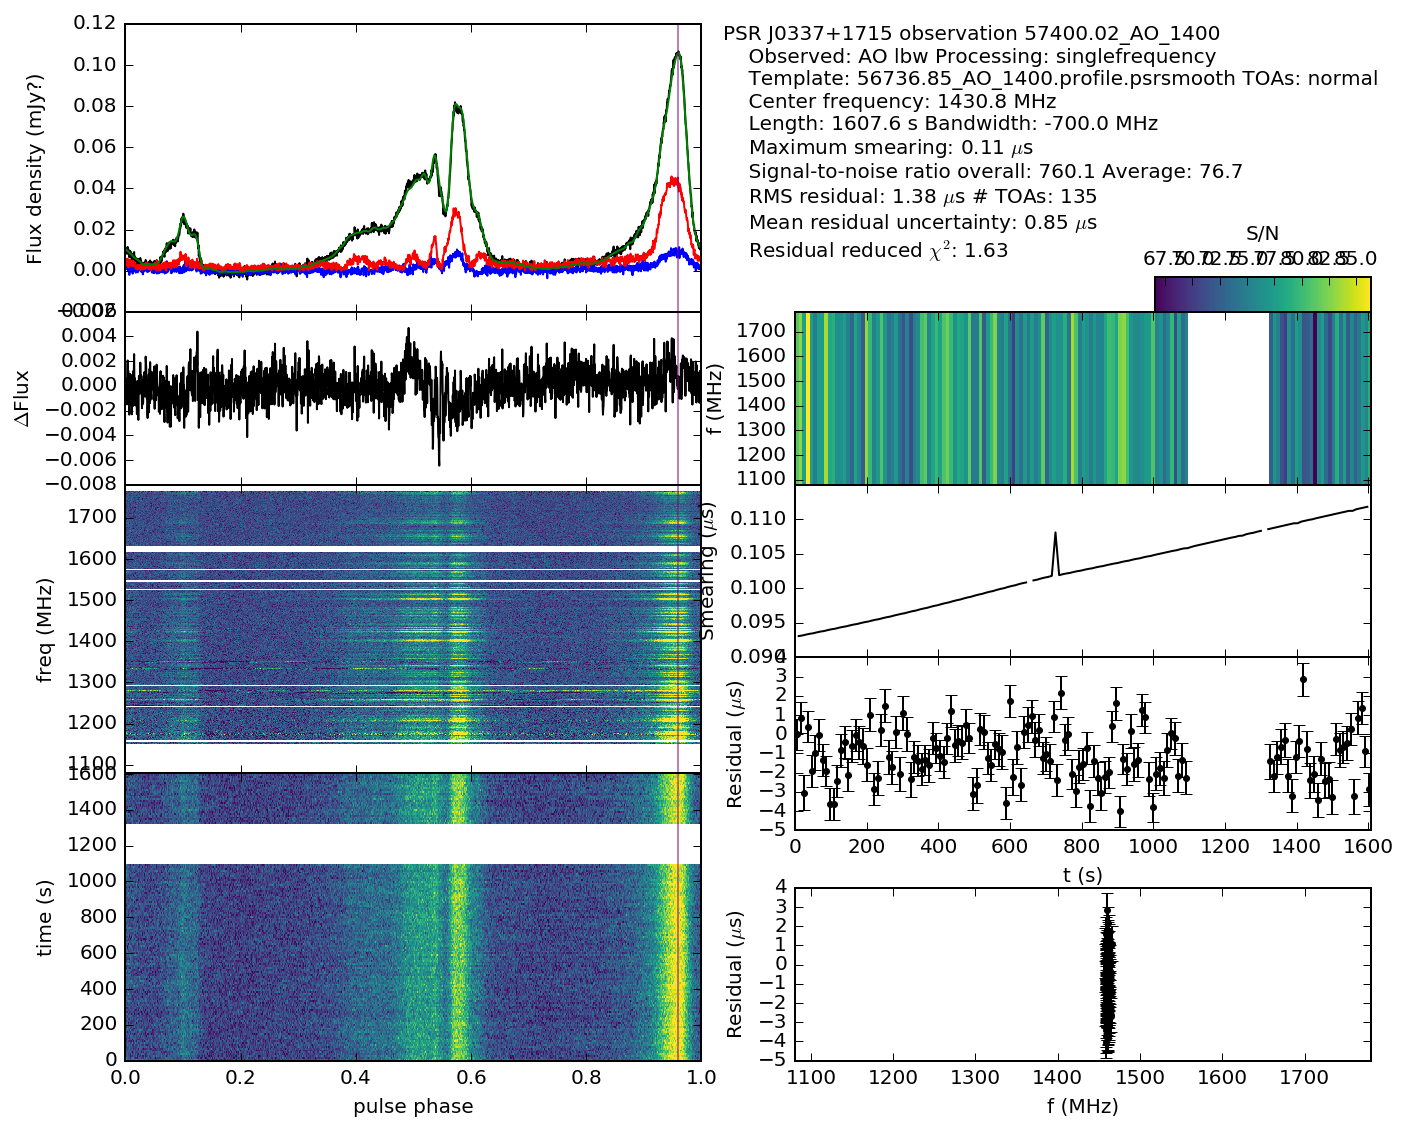

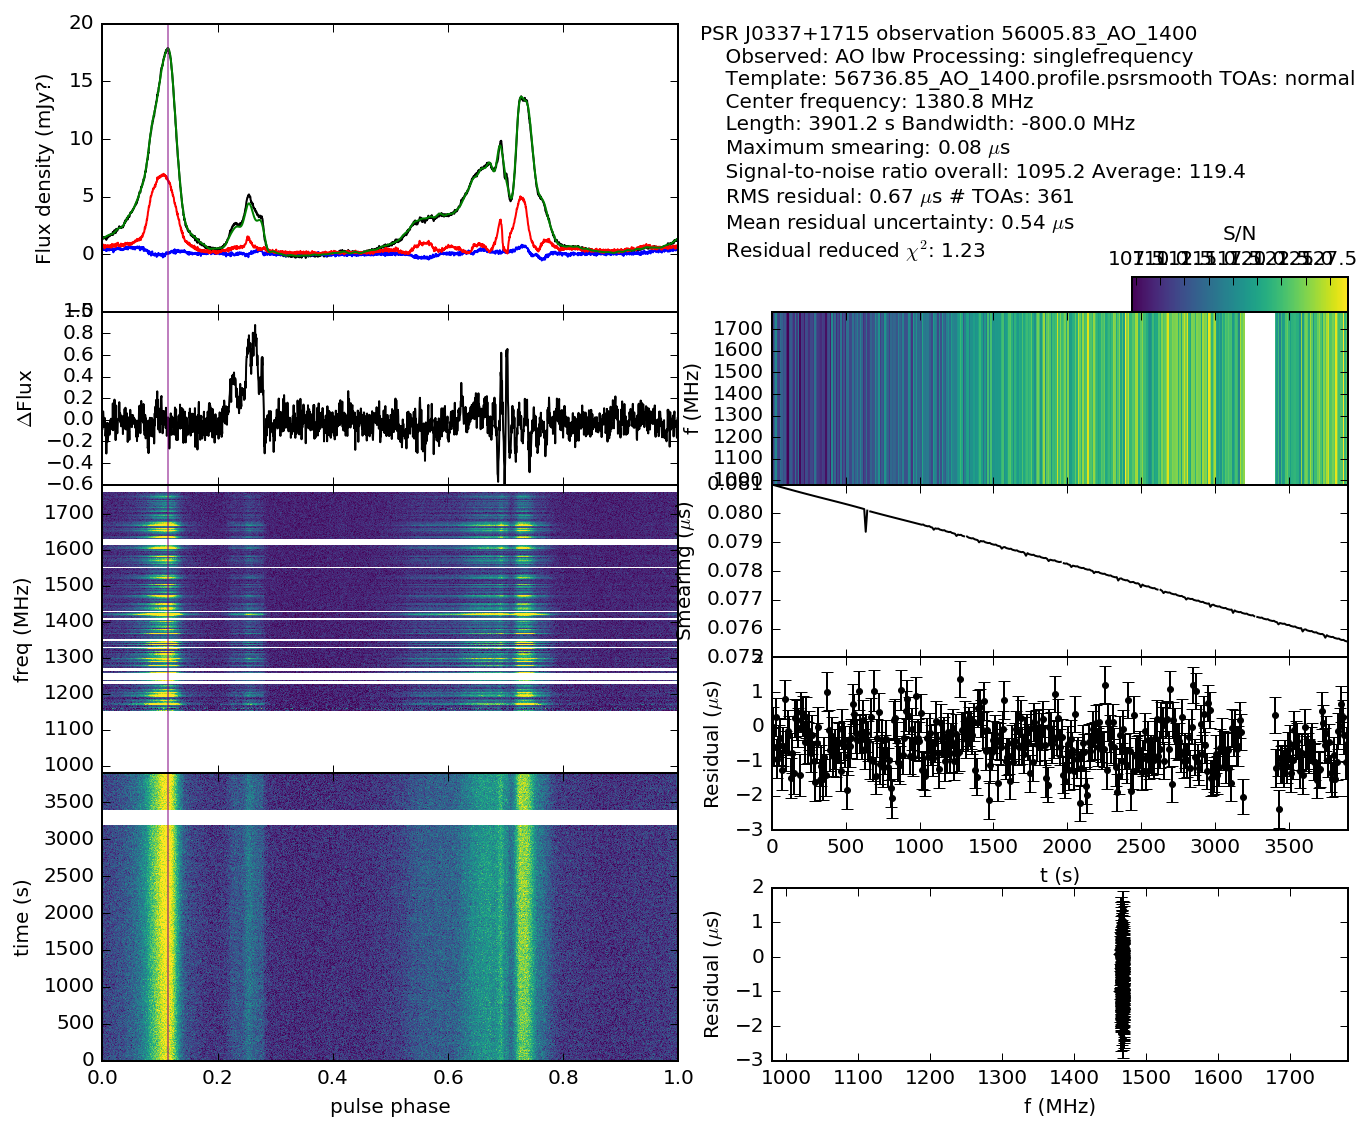

In [69]:
keyhole_obs = ["data/obs/56005.83_AO_1400",
               "data/obs/57400.02_AO_1400"]
for o in keyhole_obs[::-1]:
    make_toas.generate_specific(o, processing_name, toa_name)

## Generate summary PDF

Each processed observation comes with a summary plot. The idea is to allow inspection of the processed output for problems such as un-zapped RFI, peculiar outlier TOAs, time when the telescope wasn't on source, or messages from aliens. The summary plots are symlinked all into one place and joined into one gigantic PDF. Note that this single PDF is usually more than a gigabyte; the result of having seven hundred pages of high-resolution plots. Mass conversion to PNGs doesn't actually reduce the size much.

In [56]:
summaries = []
for s in glob(join("data/obs/*_*_*",processing_name,toa_name,"summary.pdf")):
    mjd, tel, band = s.split('/')[2].split("_")
    band = float(band)
    summaries.append((tel, -band, mjd, s))
summaries.sort()
summaries = [s for (tel, band, mjd, s) in summaries]

outname = "data/summary_%s_%s.pdf" % (processing_name, toa_name)
print outname, len(summaries)
if len(summaries)==0:
    raise ValueError("No summmary plots found for %s/%s" % (processing_name, toa_name))
subprocess.check_call(["pdfunite"]+summaries+[outname])

data/summary_tuned_mueller.pdf 788


0

In [57]:
# Make symlinks all in the same directory
summary_dir = join("data/summary", processing_name, toa_name)
if os.path.exists(summary_dir):
    shutil.rmtree(summary_dir)
os.makedirs(summary_dir)
for s in glob(join("data/obs/*_*_*",processing_name,toa_name,"summary.pdf")):
    obsname = s.split('/')[2]
    target_name = join(summary_dir, obsname+".pdf")
    os.symlink(join(os.getcwd(),s), target_name)
    #print s, target_name

## Make TOAs file

Collect all the TOAs into one file, named by `processing_name` and `toa_name`. Dates might be desirable too, but for automatically-generated TOA files they're less necessary and can be done by hand if desired.

In [52]:
toalines = []
for s in glob(join("data/obs/*_*_*",processing_name,toa_name,"toas.tim")):
    with open(s,"rt") as f:
        for l in f.readlines():
            if l.split() != ["FORMAT","1"]:
                toalines.append(l)
timfile = "data/%s_%s.tim" % (processing_name, toa_name)
with open(timfile, "wt") as f:
    f.write("FORMAT 1\n")
    for l in toalines:
        f.write(l)
print timfile
print len(toalines), "TOAs"

data/tuned_mueller.tim
29744 TOAs


## Check for new zapping instructions

Manual zapping is best done with `pazi`, which can be induced to print out the `paz` commands necessary to replicate the zapping. These commands should be saved in files like `raw_0000.ar.paz`, which are then applied during processing. Note that these files are not executed; instead they're parsed and the channels and subints to zap are extracted and applied as part of the processsing. In any case, if one has gone through and manually zapped some observations, this block will detect any observations that need to be reprocessed, and optionally delete the processed data so that reprocessing will happen when `make_toas.py` is run.

In [53]:
total = set()
old = set()
# note that missing can include observations that aren't meant to be processed with these settings
# for example if you create zapping instructions for a 2000 MHz observation but there's no schema
# for processing such a thing (we have maybe three and they're terrible for timing)
missing = set()
for zi in sorted(glob("data/obs/*/*.paz")):
    d = os.path.dirname(zi)
    p = join(d,processing_name)
    total.add(p)
    if os.path.exists(p):
        if os.path.getmtime(p)<os.path.getmtime(zi):
            old.add(p)
    else:
        missing.add(p) 
for p in sorted(old):
    print p
    # shutil.rmtree(p)
print len(total), len(old), len(missing)

33 0 3


## Look at known bad observations

Observations can be marked with a file `knownbad` to indicate that something consistently prevents them being processed. This file should contain a brief description of the problem. If the problem is resolved, I recommend moving the file aside but keeping it as a record of trouble.

In [14]:
for kb in sorted(glob("data/obs/*/knownbad")):
    o = os.path.dirname(kb)
    p = pickle.load(open(join(o,"meta.pickle"),"rb"))
    rf = p["input_files"][0]
    print o, rf, len(p["input_files"])
    print open(kb).read().strip()

data/obs/56781.75_AO_2000 /psr_archive/hessels/archibald/0337+17/raw/AO/puppi_56781_J0337+1715_1039_0001.fits 7
Later observations have more channels than the first
data/obs/57591.44_GBT_1400 /psr_archive/hessels/archibald/0337+17/raw/GBT/new/guppi_57591_0337+17_0003_0001.fits 13
One GPU seems to have dropped out partway through
data/obs/57594.47_AO_1400 /psr_archive/hessels/archibald/0337+17/raw/AO/puppi_57594_J0337+1715_0454_0001.fits 1
No visible signal anywhere; zapping wipes everything out
data/obs/57594.48_AO_1400 /psr_archive/hessels/archibald/0337+17/raw/AO/puppi_57594_J0337+1715_0456_0001.fits 1
No visible signal anywhere; zapping wipes everything out


## Delete processed observations

Each set of processed observations takes up about 2 TB, primarily for the calibrated, aligned, zapped, but not downsampled data (e.g. `zap_0000.ar`). This block is for deleting old ones, either to free up space or to induce reprocessing after a change in the code.

In [47]:
def delete_processed(processing_name):
    for o in sorted(glob(join("data/obs/*_*_*",processing_name))):
        print o
        shutil.rmtree(o)
def delete_toas(processing_name,toa_name):
    for o in sorted(glob(join("data/obs/*_*_*",processing_name,toa_name))):
        print o
        shutil.rmtree(o)

In [48]:
delete_processed("tuned")

data/obs/55956.63_WSRT_1400/tuned
data/obs/55956.64_WSRT_1400/tuned
data/obs/55956.65_WSRT_1400/tuned
data/obs/55956.66_WSRT_1400/tuned
data/obs/55956.67_WSRT_1400/tuned
data/obs/55956.68_WSRT_1400/tuned
data/obs/55956.69_WSRT_1400/tuned
data/obs/55956.70_WSRT_1400/tuned
data/obs/55956.71_WSRT_1400/tuned
data/obs/55956.72_WSRT_1400/tuned
data/obs/55959.71_WSRT_1400/tuned
data/obs/55959.72_WSRT_350/tuned
data/obs/55961.86_WSRT_1400/tuned
data/obs/55961.87_WSRT_350/tuned
data/obs/55962.26_GBT_1400/tuned
data/obs/55964.00_GBT_1400/tuned
data/obs/55966.82_WSRT_1400/tuned
data/obs/55966.84_WSRT_350/tuned
data/obs/55967.72_WSRT_1400/tuned
data/obs/55967.78_WSRT_350/tuned
data/obs/55968.72_WSRT_1400/tuned
data/obs/55968.77_WSRT_350/tuned
data/obs/55970.22_GBT_1400/tuned
data/obs/55972.70_WSRT_1400/tuned
data/obs/55972.74_WSRT_350/tuned
data/obs/55973.22_GBT_1400/tuned
data/obs/55976.09_GBT_1400/tuned
data/obs/55977.72_WSRT_1400/tuned
data/obs/55977.83_WSRT_350/tuned
data/obs/55978.91_GBT_1400

## Identify missing-summary anomalies

Sometimes for some reason the summary plot is not generated but the rest of the TOA generation proceeds without error. These observations need to be cleaned up to allow reprocessing once the problem is fixed.

In [31]:
for s in sorted(glob(join("data/obs/*_*_*",processing_name,toa_name))):
    if not os.path.exists(join(s,"summary.pdf")):
        print s
        shutil.rmtree(s)

data/obs/56479.20_WSRT_350/tuned/mueller


In [19]:
for s in sorted(glob(join("data/obs/*_*_*",processing_name))):
    if not os.path.exists(join(s,toa_name)):
        print s

## Check out GBT mystery jump

GBT search-mode observations are not clearly marked as such once they have been folded, but there is a substantial phase shift between these and fold-mode observations. Use these blocks to test they've been correctly marked.

In [42]:
obs1 = "data/obs/55962.26_GBT_1400" # search
obs2 = "data/obs/57428.86_GBT_1400" # fold

In [87]:
hdr = "SUBINT"
for k in h1[hdr].header:
    v1 = h1[hdr].header[k]
    if k in h2[hdr].header:
        v2 = h2[hdr].header[k]
        if v1 != v2:
            print k, v1, v2
        else:
            print k, v1, "missing"

XTENSION BINTABLE missing
BITPIX 8 missing
NAXIS 2 missing
NAXIS1 4214860 4216932
NAXIS2 58 128
PCOUNT 0 missing
GCOUNT 1 missing
TFIELDS 17 20
TTYPE1 TSUBINT INDEXVAL
TFORM1 1D missing
TTYPE2 OFFS_SUB TSUBINT
TFORM2 1D missing
TTYPE3 LST_SUB OFFS_SUB
TFORM3 1D missing
TTYPE4 RA_SUB LST_SUB
TFORM4 1D missing
TTYPE5 DEC_SUB RA_SUB
TFORM5 1D missing
TTYPE6 GLON_SUB DEC_SUB
TFORM6 1D missing
TTYPE7 GLAT_SUB GLON_SUB
TFORM7 1D missing
TTYPE8 FD_ANG GLAT_SUB
TFORM8 1E 1D
TTYPE9 POS_ANG FD_ANG
TFORM9 1E missing
TTYPE10 PAR_ANG POS_ANG
TFORM10 1E missing
TTYPE11 TEL_AZ PAR_ANG
TFORM11 1E missing
TTYPE12 TEL_ZEN TEL_AZ
TFORM12 1E missing
TTYPE13 DAT_FREQ TEL_ZEN
TFORM13 512E 1E
TTYPE14 DAT_WTS AUX_DM
TFORM14 512E 1D
TTYPE15 DAT_OFFS AUX_RM
TFORM15 2048E 1D
TTYPE16 DAT_SCL DAT_FREQ
TFORM16 2048E 512D
TTYPE17 DATA DAT_WTS
TFORM17 1048576E 512E
INT_TYPE TIME missing
INT_UNIT SEC missing
SCALE FluxDen missing
NPOL 4 missing
POL_TYPE AABBCRCI missing
TBIN 1.024e-05 6.4e-07
NBIN 512 1024
NBIN_PRD 0 

In [63]:
gbt_obs = "data/obs/*_GBT_1400"
for o in sorted(glob(gbt_obs)):
    h = fits.open(join(o,"raw_0000.ar"))
    print os.path.basename(o), h['subint'].header['tbin'], h['subint'].header['nbin']
    h.close()

 55962.26_GBT_1400 1.024e-05 512
55964.00_GBT_1400 1.024e-05 512
55970.22_GBT_1400 1.024e-05 512
55973.22_GBT_1400 1.024e-05 512
55976.09_GBT_1400 1.024e-05 512
55978.91_GBT_1400 1.024e-05 512
55982.18_GBT_1400 1.024e-05 512
55986.18_GBT_1400 1.024e-05 512
55986.19_GBT_1400 1.024e-05 512
55992.12_GBT_1400 1.024e-05 512
55994.88_GBT_1400 1.024e-05 512
55997.81_GBT_1400 1.024e-05 512
55999.00_GBT_1400 1.024e-05 512
55999.87_GBT_1400 1.024e-05 512
56003.13_GBT_1400 1.024e-05 512
56006.14_GBT_1400 1.024e-05 512
56009.64_GBT_1400 1.024e-05 512
56014.86_GBT_1400 1.024e-05 512
56014.87_GBT_1400 1.024e-05 512
56018.73_GBT_1400 1.024e-05 512
56021.73_GBT_1400 1.024e-05 512
56029.01_GBT_1400 1.024e-05 512
56034.89_GBT_1400 6.4e-07 1024
56036.99_GBT_1400 6.4e-07 1024
56039.69_GBT_1400 6.4e-07 1024
56041.94_GBT_1400 6.4e-07 1024
56044.97_GBT_1400 1.024e-05 512
56047.97_GBT_1400 6.4e-07 1024
56050.90_GBT_1400 6.4e-07 1024
56053.91_GBT_1400 6.4e-07 1024
56056.75_GBT_1400 6.4e-07 1024
56060.72_GBT_14

In [65]:
ao_obs = "data/obs/*_AO_1400"
for o in sorted(glob(ao_obs)):
    h = fits.open(join(o,"raw_0000.ar"))
    print os.path.basename(o), h['subint'].header['tbin'], h['subint'].header['nbin']
    h.close()

55989.87_AO_1400 6.4e-07 2048
55992.86_AO_1400 6.4e-07 2048
55995.86_AO_1400 6.4e-07 2048
55995.89_AO_1400 6.4e-07 2048
55995.92_AO_1400 6.4e-07 2048
55998.86_AO_1400 6.4e-07 2048
55998.91_AO_1400 6.4e-07 2048
56001.83_AO_1400 6.4e-07 2048
56005.83_AO_1400 6.4e-07 2048
56008.82_AO_1400 6.4e-07 2048
56012.82_AO_1400 6.4e-07 2048
56015.80_AO_1400 6.4e-07 2048
56018.79_AO_1400 6.4e-07 2048
56021.77_AO_1400 6.4e-07 2048
56025.79_AO_1400 6.4e-07 2048
56030.75_AO_1400 6.4e-07 2048
56033.74_AO_1400 6.4e-07 2048
56036.73_AO_1400 6.4e-07 2048
56039.72_AO_1400 6.4e-07 2048
56042.71_AO_1400 6.4e-07 2048
56046.71_AO_1400 6.4e-07 2048
56050.72_AO_1400 6.4e-07 2048
56053.70_AO_1400 6.4e-07 2048
56053.72_AO_1400 6.4e-07 2048
56056.68_AO_1400 6.4e-07 2048
56060.67_AO_1400 6.4e-07 2048
56063.66_AO_1400 6.4e-07 2048
56067.65_AO_1400 6.4e-07 2048
56073.62_AO_1400 6.4e-07 2048
56076.61_AO_1400 6.4e-07 2048
56080.62_AO_1400 6.4e-07 2048
56084.63_AO_1400 6.4e-07 2048
56087.62_AO_1400 6.4e-07 2048
56095.61_A

In [100]:
# reprocess unmarked search-mode data
gbt_obs = "data/obs/*_GBT_1400"
for o in sorted(glob(gbt_obs)):
    h = fits.open(join(o,"raw_0000.ar"))
    tbin = h['subint'].header['tbin']
    pn = join(o,processing_name)
    if not os.path.exists(pn):
        continue
    meta = pickle.load(open(join(pn,"process.pickle")))
    if tbin>5e-6 and "mode" not in meta and os.path.exists(pn):
        print o
        #shutil.rmtree(pn)
    h.close()